In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import statsmodels.formula.api as smf

import geopandas as gpd

In [2]:
from kmodes.kmodes import KModes

In [3]:
from census import Census
from us import states


In [4]:
full_results = pd.read_csv('../../cc_election_cleaning/election_results_with_vote_sponsor_cluster_FEB13.csv')
occ_df = pd.read_csv('../../cc_election_cleaning/occupation_election_feb21.csv')
dldc = pd.read_csv('../../cc_election_cleaning/district_level_demo_clusters.csv')
ae = pd.read_csv('../../cc_election_cleaning/ae_precincts.csv')

In [5]:
fwe = pd.read_csv('../data/finance_with_ethnicity.csv')

In [6]:
occ_df = pd.read_csv('../../cc_election_cleaning/occupation_election_feb21.csv')
p_cols = [col for col in occ_df.columns if col[-1] == 'p']
wp_cols = [col for col in occ_df.columns if col.startswith("w2") and col.endswith("p")]
to_remove = [ 'w2psp',
 'w2sep',
 'w2npp',
 'w2govp',
 'w2nip','w2cop']
wp_cols = [col for col in wp_cols if col not in to_remove]

In [ ]:
dldc.sort_values(by='demo_cluster')

In [7]:
full_results_winner = full_results[full_results['winner'] == True]
full_results_winner = full_results_winner.merge(ae[['ElectDist','bang21p','ind21p']], left_on='ed_name',right_on='ElectDist')
full_results_winner = full_results_winner.merge(occ_df, left_on='ElectDist',right_on='ElectDist')

In [8]:
key_demo_cols = [ 'district', 'cvap21bapp', 'mhhi21','h21p', 'nha21p', 'nhb21p', 'nhw21p','winda21p', 'white_transplant_ratio','bang21p', 'ind21p','venez21p','chin21p',
                 'kor21p','colomb21p','domin21p','mex21p'] + wp_cols 
full__results_key_demo = full_results_winner[key_demo_cols]
ag = full__results_key_demo.groupby('district').agg('mean').reset_index()

In [9]:
demographic_cols = ['cvap21bapp', 'mhhi21', 'h21p', 'nha21p', 'nhb21p', 'nhw21p','winda21p', 'white_transplant_ratio','bang21p', 'ind21p','venez21p','chin21p',
                 'kor21p','colomb21p','domin21p','mex21p'] + wp_cols

In [10]:
for col in demographic_cols:
    ag[col + '_quintile'] = pd.qcut(ag[col], 5, labels=False) + 1

In [11]:
pd.set_option('display.max_columns', None)

In [12]:
ag[ag['district'] == 22]

,district,cvap21bapp,mhhi21,h21p,nha21p,nhb21p,nhw21p,winda21p,white_transplant_ratio,bang21p,ind21p,venez21p,chin21p,kor21p,colomb21p,domin21p,mex21p,w2mgtp,w2banp,w2cmp,w2aep,w2scip,w2cossp,w2lawp,w2edup,w2admp,w2docp,w2htp,w2hsp,w2ffp,w2copp,w2foodp,w2bgp,w2pservep,w2salep,w2oadp,w2farmp,w2conp,w2emrp,w2prodp,w2tranp,w2matp,cvap21bapp_quintile,mhhi21_quintile,h21p_quintile,nha21p_quintile,nhb21p_quintile,nhw21p_quintile,winda21p_quintile,white_transplant_ratio_quintile,bang21p_quintile,ind21p_quintile,venez21p_quintile,chin21p_quintile,kor21p_quintile,colomb21p_quintile,domin21p_quintile,mex21p_quintile,w2mgtp_quintile,w2banp_quintile,w2cmp_quintile,w2aep_quintile,w2scip_quintile,w2cossp_quintile,w2lawp_quintile,w2edup_quintile,w2admp_quintile,w2docp_quintile,w2htp_quintile,w2hsp_quintile,w2ffp_quintile,w2copp_quintile,w2foodp_quintile,w2bgp_quintile,w2pservep_quintile,w2salep_quintile,w2oadp_quintile,w2farmp_quintile,w2conp_quintile,w2emrp_quintile,w2prodp_quintile,w2tranp_quintile,w2matp_quintile
21,22,49.746467,39873.545388,25.925276,14.958679,3.60946,51.19132,0.337785,11.642818,1.404666,3.818585,0.381695,3.838968,1.155929,3.424922,2.669103,5.242352,12.171865,7.318634,4.832265,1.40507,1.433253,1.71961,2.262646,7.089404,7.390982,3.229881,1.879323,5.740568,2.789363,1.664375,13.627086,7.571923,7.314773,16.032173,19.861072,0.080719,8.312774,1.757711,1.750519,3.88381,1.247793,4,4,3,4,1,4,1,4,5,5,5,3,4,5,2,4,4,4,4,4,5,2,4,4,4,3,2,1,2,3,4,3,3,2,2,3,3,3,2,2,1


In [13]:
ag[ag['cvap21bapp_quintile'] > ag['mhhi21_quintile']][['district','cvap21bapp_quintile','mhhi21_quintile']].sort_values(by='cvap21bapp_quintile')

,district,cvap21bapp_quintile,mhhi21_quintile
8,9,3,1
9,10,3,1
10,11,3,2
24,25,3,2
6,7,4,1
33,34,4,3
35,36,4,2
39,40,4,2
47,48,4,2
0,1,5,4


Look at citywide structure of occupation and race

In [9]:
p_cols = [col for col in occ_df.columns if col[-1] == 'p']
wp_cols = [col for col in occ_df.columns if col.startswith("w2") and col.endswith("p")]
wp_cols.remove('w2cop')

In [10]:
top_std_cols = occ_df[wp_cols].std().nlargest(11).index.tolist()

In [11]:
demographic_cols = ['cvap21bapp', 'mhhi21', 'h21p', 'nha21p', 'nhb21p', 'nhw21p','winda21p', 'white_transplant_ratio','hh21op','bus_ratio','drive_ratio','mex21p', 'prican21p', 'domin21p', 'colomb21p', 'kor21p', 'chin21p']
demographic_cols.extend(top_std_cols)

In [35]:
demo_occ = pd.merge(full_results_winner, occ_df, left_on='ElectDist', right_on='ElectDist')

In [14]:
demo_occ.shape

(6247, 281)

In [17]:
df_cluster = demo_occ[demographic_cols]

In [ ]:
df_cluster = demo_occ[demographic_cols]
scaler = StandardScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster)

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

Text(0.5, 1.0, 'Elbow Method')

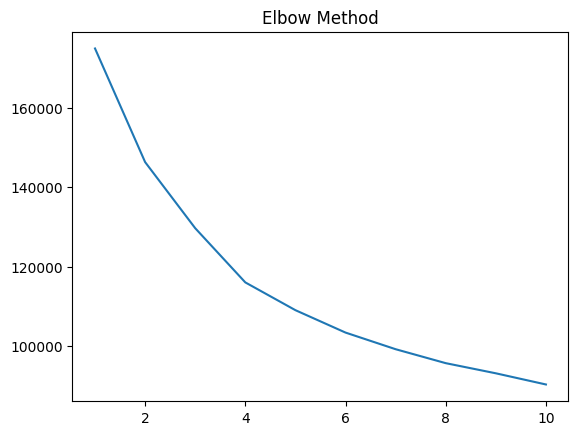

In [20]:
# elbow method to determine number of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(df_cluster_scaled)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 11), inertia)
plt.title('Elbow Method')

In [26]:
kmeans = KMeans(n_clusters=8, random_state=0)
kmeans.fit(df_cluster_scaled)
df_cluster['cluster'] = kmeans.labels_

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\samtg\AppData\Local\Temp\ipykernel_4028\394701120.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster['cluster'] = kmeans.labels_


In [28]:
averages = df_cluster.groupby('cluster')[demographic_cols].mean().round(2)

In [29]:
race_cols = ['nha21p', 'nhb21p', 'nhw21p','h21p']
averages['top_race'] = averages[race_cols].idxmax(axis=1)

In [36]:
averages[['top_race','mhhi21', 'white_transplant_ratio'] + top_std_cols].sort_values(by='mhhi21')

,top_race,mhhi21,white_transplant_ratio,w2psp,w2hsp,w2oadp,w2conp,w2foodp,w2salep,w2govp,w2bgp,w2mgtp,w2npp,w2pservep
cluster,,,,,,,,,,,,,,
5,h21p,13264.59,2.15,67.72,23.30,22.20,8.00,15.23,16.90,13.57,15.20,6.13,11.07,9.20
2,nhw21p,25029.82,9.34,59.30,9.22,21.86,5.75,8.99,15.38,12.46,6.11,11.60,15.35,6.18
6,nha21p,29982.86,2.10,69.64,19.78,21.84,12.78,16.46,19.37,10.16,7.68,7.43,8.40,10.87
3,nhb21p,33451.12,1.19,59.82,20.35,24.11,8.39,6.63,13.06,22.84,7.85,6.68,10.18,6.59
0,h21p,33855.47,2.86,69.69,13.64,23.59,22.00,21.80,21.23,9.97,15.29,6.63,7.73,8.81
1,nha21p,38279.44,1.97,62.69,7.22,22.04,7.46,7.21,22.64,14.40,4.51,11.80,9.02,7.72
4,nhw21p,42085.97,25.93,65.46,2.24,12.34,1.77,4.16,18.51,7.72,1.90,19.92,12.83,4.53
7,nhw21p,43920.97,2.58,60.28,11.07,24.81,10.07,7.16,18.18,18.39,6.16,9.82,9.13,5.86


In [37]:
df_cluster.shape

(6247, 29)

Try EFA

In [98]:
demographic_cols = ['cvap21bapp', 'mhhi21', 'h21p', 'nha21p', 'nhb21p', 'nhw21p', 'white_transplant_ratio','hh21op','bus_ratio','drive_ratio','mean_noise']
demographic_cols.extend(top_std_cols)

In [114]:
demo_occ.columns

Index(['Precinct', 'vote', 'total_vote_precinct', 'vote_share', 'ed_name',
       'winner', 'rank', 'district', 'candidate', 'matched_name',
       ...
       'wf2cop', 'w2psp', 'w2sep', 'w2npp', 'w2govp', 'w2nip', 'kdh24p',
       'djt24p', 'wfp24p', 'con24p'],
      dtype='object', length=281)

In [99]:
df_cluster = demo_occ[demographic_cols]
scaler = StandardScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster)

In [100]:
fa = FactorAnalyzer(rotation=None)
fa.fit(df_cluster_scaled)

FactorAnalyzer(rotation=None, rotation_kwargs={})

In [101]:
eigenvalues, _ = fa.get_eigenvalues()
print("Eigenvalues:", eigenvalues)

Eigenvalues: [5.73203569 3.07148367 2.39110417 1.07020701 1.0552879  0.96029652
 0.8929574  0.84253349 0.81033837 0.75153116 0.67247176 0.64920021
 0.5397435  0.51134517 0.47279921 0.41268472 0.38477947 0.25745352
 0.24225478 0.15693139 0.10900874 0.01355214]


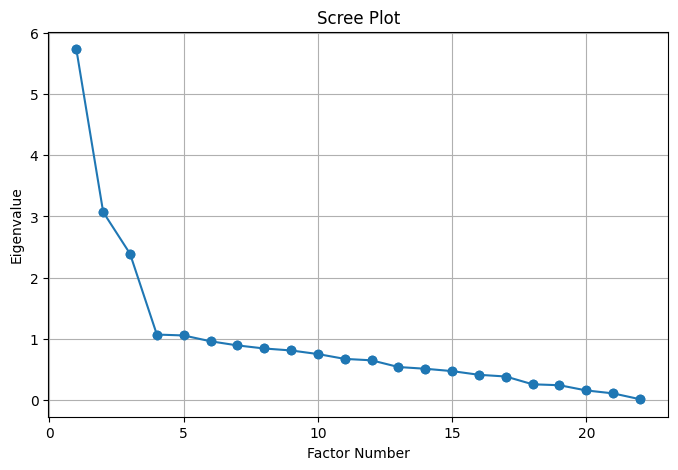

In [102]:
plt.figure(figsize=(8, 5))
plt.scatter(range(1, len(eigenvalues) + 1), eigenvalues)
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.title('Scree Plot')
plt.xlabel('Factor Number')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()

In [103]:
num_factors = 4
fa = FactorAnalyzer(n_factors=num_factors, rotation='varimax')
fa.fit(df_cluster_scaled)

FactorAnalyzer(n_factors=4, rotation='varimax', rotation_kwargs={})

In [104]:
df_cluster_scaled_factors = fa.transform(df_cluster_scaled)

In [105]:
df_cluster_scaled_factors = pd.DataFrame(df_cluster_scaled_factors, columns=[f'factor_{i}' for i in range(num_factors)])

In [106]:
df_cluster_scaled_factors['ed_name'] = demo_occ['ed_name']

In [107]:
df_cluster_scaled_factors['top_factor'] = df_cluster_scaled_factors[[f'factor_{i}' for i in range(num_factors)]].idxmax(axis=1)

In [108]:
loadings = fa.loadings_
loadings_df = pd.DataFrame(loadings, index=df_cluster.columns, 
                           columns=[f'Factor{i+1}' for i in range(num_factors)])
print("Factor Loadings:\n", loadings_df)

Factor Loadings:
                          Factor1   Factor2   Factor3   Factor4
cvap21bapp             -0.897136  0.265259 -0.044218  0.096595
mhhi21                 -0.130849  0.384571  0.058620  0.051149
h21p                    0.426628 -0.697213  0.097864  0.232432
nha21p                  0.020515  0.327904  0.473374  0.187147
nhb21p                  0.351936 -0.079965 -0.331190 -0.875794
nhw21p                 -0.649668  0.383236 -0.134356  0.364610
white_transplant_ratio -0.918936 -0.068504 -0.049997  0.015372
hh21op                  0.090716  0.852552 -0.075619  0.166109
bus_ratio               0.556142 -0.081727 -0.071534 -0.148856
drive_ratio             0.531346  0.677270 -0.081885  0.152064
mean_noise              0.026852 -0.321364 -0.043873  0.000101
w2psp                  -0.010969 -0.207822  0.655385 -0.095922
w2hsp                   0.577766 -0.297391  0.098917 -0.243934
w2oadp                  0.396414  0.111756  0.070389 -0.015364
w2conp                  0.410611  0.0

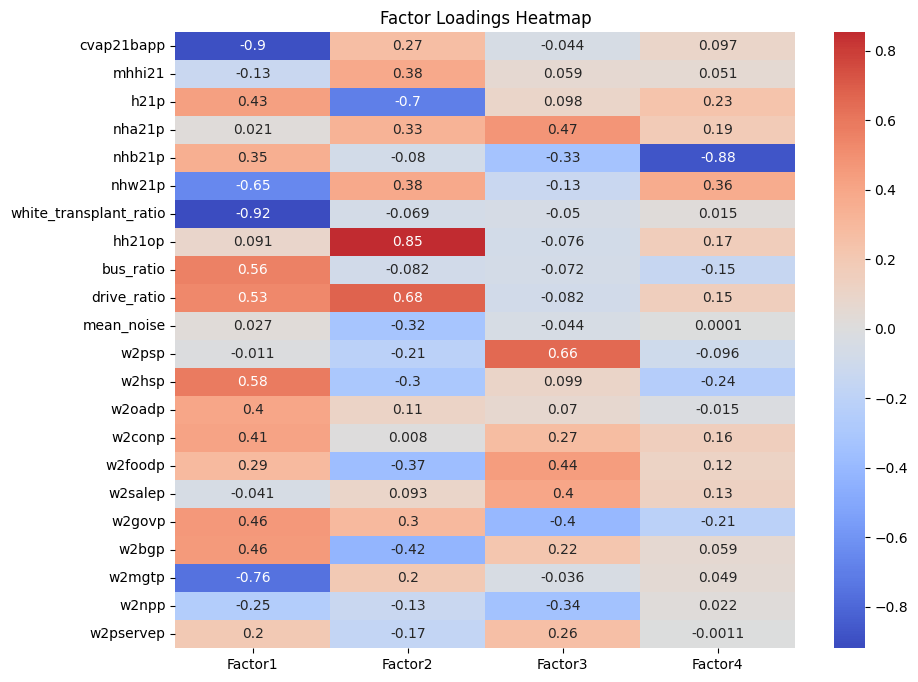

In [109]:
plt.figure(figsize=(10, 8))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', center=0)
plt.title("Factor Loadings Heatmap")
plt.show()

In [111]:
communalities = fa.get_communalities()
communalities_df = pd.DataFrame(communalities, index=df_cluster.columns, columns=['Communalities'])
print("Communalities:\n", communalities_df)

Communalities:
                         Communalities
cvap21bapp                   0.886500
mhhi21                       0.171069
h21p                         0.731719
nha21p                       0.367048
nhb21p                       1.006955
nhw21p                       0.719929
white_transplant_ratio       0.851871
hh21op                       0.768385
bus_ratio                    0.343249
drive_ratio                  0.770852
mean_noise                   0.105921
w2psp                        0.482040
w2hsp                        0.491544
w2oadp                       0.174824
w2conp                       0.268613
w2foodp                      0.427001
w2salep                      0.184930
w2govp                       0.506854
w2bgp                        0.437011
w2mgtp                       0.617142
w2npp                        0.197193
w2pservep                    0.134768


In [116]:
test = df_cluster_scaled_factors.merge(demo_occ[['ed_name','djt24p']], on='ed_name')

In [117]:
target = 'djt24p'
mod = sm.OLS(test[target], sm.add_constant(test[[f'factor_{i}' for i in range(num_factors)]]))
res = mod.fit()

Look at citywide breakdown of job, education, income 

In [130]:
top_mean_cols

['w2psp',
 'w2oadp',
 'w2salep',
 'w2govp',
 'w2hsp',
 'w2npp',
 'w2mgtp',
 'w2foodp',
 'w2conp',
 'w2bgp',
 'w2pservep',
 'w2edup',
 'w2banp',
 'w2nip',
 'w2tranp',
 'w2admp',
 'w2ffp',
 'w2docp',
 'w2sep',
 'w2cmp']

In [ ]:
['w2mgtp','w2banbp','w2cmp','w2aep','w2scip','w2cossp','w2lawp','w2edup','w2admp','w2docp',]

In [131]:
wp_cols

['w2mgtp',
 'w2banp',
 'w2cmp',
 'w2aep',
 'w2scip',
 'w2cossp',
 'w2lawp',
 'w2edup',
 'w2admp',
 'w2docp',
 'w2htp',
 'w2hsp',
 'w2ffp',
 'w2copp',
 'w2foodp',
 'w2bgp',
 'w2pservep',
 'w2salep',
 'w2oadp',
 'w2farmp',
 'w2conp',
 'w2emrp',
 'w2prodp',
 'w2tranp',
 'w2matp',
 'w2psp',
 'w2sep',
 'w2npp',
 'w2govp',
 'w2nip']

In [132]:
to_remove = [ 'w2psp',
 'w2sep',
 'w2npp',
 'w2govp',
 'w2nip']
wp_cols = [col for col in wp_cols if col not in to_remove]

In [22]:
top_mean_cols = occ_df[wp_cols].mean().nlargest(20).index.tolist()

In [ ]:
demo_occ[wp_cols]

w2oadp       21.356286
w2salep      17.305053
w2hsp        13.378735
w2mgtp       10.345876
w2foodp      10.066707
w2conp        8.358332
w2bgp         8.131583
w2pservep     6.979978
w2edup        6.763752
w2banp        6.315915
w2tranp       4.620273
w2admp        4.328931
w2docp        4.047364
w2ffp         3.949643
w2cmp         3.405054
w2htp         3.193492
w2cossp       2.193999
w2prodp       2.180424
w2matp        2.148651
w2lawp        2.085900
dtype: float64

In [17]:
key_demo_cols = [ 'cvap21bapp',
 'mhhi21',
 'h21p',
 'nha21p',
 'nhb21p',
 'nhw21p']

In [20]:
for col in key_demo_cols:
    demo_occ[col + '_quintile'] = pd.qcut(demo_occ[col], 3, labels=False) + 1

In [23]:
demo_occ.groupby('cvap21bapp_quintile')[top_mean_cols].mean()

,w2psp,w2oadp,w2salep,w2govp,w2hsp,w2npp,w2mgtp,w2foodp,w2conp,w2bgp,w2pservep,w2edup,w2banp,w2nip,w2tranp,w2admp,w2ffp,w2docp,w2sep,w2cmp
cvap21bapp_quintile,,,,,,,,,,,,,,,,,,,,
1,65.481317,24.427641,17.373484,15.148218,20.918936,10.239434,6.207370,12.915304,11.032433,12.560703,8.375307,5.549881,3.192628,5.362413,6.435769,1.575371,5.636201,2.348001,2.056545,1.740600
2,62.883488,23.081135,17.052454,16.168437,13.877228,10.380306,8.934517,11.241652,9.966566,8.097557,7.245106,7.252168,5.377504,5.840873,5.249457,3.465033,4.127875,4.147720,3.374888,3.131177
3,62.469505,16.558606,17.489188,10.999696,5.336420,12.781087,15.897729,6.041796,4.074712,3.734362,5.318849,7.489791,10.379113,7.026927,2.174722,7.947711,2.084045,5.647186,5.317355,5.344184


In [24]:
grouped = demo_occ.groupby('mhhi21_quintile')[top_mean_cols].mean()
top_three_values = grouped.apply(lambda row: row.nlargest(3), axis=1)
print(top_three_values)


                    w2hsp     w2oadp      w2psp    w2salep
mhhi21_quintile                                           
1                16.70399  21.965228  64.088152        NaN
2                     NaN  21.379494  64.247283  17.506613
3                     NaN  20.723528  62.498704  17.721330


In [25]:
mean_values = demo_occ.groupby('cvap21bapp_quintile')[top_mean_cols].agg("mean")
diffs = mean_values.max() - mean_values.min()  
top_diff_cols = diffs.nlargest(10)
print(top_diff_cols)

w2hsp      15.582516
w2mgtp      9.690359
w2bgp       8.826341
w2oadp      7.869035
w2banp      7.186485
w2conp      6.957721
w2foodp     6.873508
w2admp      6.372340
w2govp      5.168741
w2tranp     4.261047
dtype: float64


In [26]:
demo_occ[['ed_name','cvap21bapp_quintile','mhhi21_quintile']].groupby(['cvap21bapp_quintile','mhhi21_quintile']).count()

ed_name
cvap21bapp_quintile mhhi21_quintile         
1                   1                   1016
                    2                    599
                    3                    468
2                   1                    579
                    2                    722
                    3                    781
3                   1                    488
                    2                    762
                    3                    832

In [116]:
conditions = [
    (demo_occ["cvap21bapp_quintile"] == 1) & 
    (demo_occ["mhhi21_quintile"].isin([2,3])),
    
    (demo_occ["cvap21bapp_quintile"] == 3) & 
    (demo_occ["mhhi21_quintile"].isin([1,2])),

    (demo_occ["cvap21bapp_quintile"] == 3) &
    (demo_occ["mhhi21_quintile"] == 3),

    (demo_occ["cvap21bapp_quintile"] == 1 ) &
    (demo_occ["mhhi21_quintile"] == 1),

    (demo_occ["cvap21bapp_quintile"] == 2 ) &
    (demo_occ["mhhi21_quintile"] == 2)
]

values = ['over_paid', 'under_paid','highed_hihghin','lowed_lowhin','mided_midhin'] 
demo_occ["ed_inc"] = np.select(conditions, values, default=0)

In [117]:
occ_col_names = ['occ','desc1','desc2','category']

In [118]:
occ_cols = pd.read_excel("../../john_data/occupation_variables.xlsx", sheet_name=1, header=None, names=occ_col_names) 
occ_wp_cols = occ_cols[occ_cols['occ'].isin(wp_cols)]

In [119]:
col_mapping = occ_wp_cols.set_index('occ')['desc2'].to_dict()

In [120]:
# make a list of col_mapping's keys
keys = list(col_mapping.keys())
values = list(col_mapping.values())

In [121]:
demo_occ_renamed = demo_occ.rename(columns=col_mapping)

In [122]:
demo_occ_renamed = demo_occ_renamed.groupby(level=0, axis=1).sum()

In [123]:
demo_occ_renamed['dpp20bs'] = demo_occ_renamed['dpp20bs'] / 10

In [ ]:
demo_occ_renamed.groupby('ed_inc')[['Managers', 'Manual Crafts and Trades','Production, Professionals','Low Skill Service','Skilled White Collar']].mean()

,dpp20bs,pg20djtp,pg20jrbp,garcia213p,adams213p
ed_inc,,,,,
0,7.678786,29.257976,68.870513,34.405806,46.450501
highed_hihghin,10.272520,21.571149,75.932650,60.521216,25.342515
lowed_lowhin,8.016560,15.642313,81.075524,19.241959,63.764345
mided_midhin,7.797691,30.971134,67.090288,35.102720,45.509880
over_paid,4.427515,20.902627,77.080095,22.395326,60.092957
under_paid,13.649181,20.096701,77.683737,56.414763,28.984805


In [35]:
mean_values = demo_occ.groupby('ed_inc')[top_mean_cols].agg("mean")
diffs = mean_values.max() - mean_values.min()  
top_diff_cols = diffs.nlargest(10)
print(top_diff_cols)

w2hsp      18.420015
w2mgtp     10.807999
w2bgp      10.261461
w2oadp      8.529908
w2conp      8.326780
w2banp      7.711379
w2foodp     7.494554
w2admp      6.595917
w2govp      5.701448
w2tranp     4.302902
dtype: float64


In [ ]:
demo_occ_map = ed_gdf.merge(demo_occ[['ed_name','ed_inc']], left_on='ElectDist', right_on='ed_name')
demo_occ_map = gpd.GeoDataFrame(demo_occ_map)

Let's do some PCA on the occupations to see if we get a better income and education variance

In [125]:
from sklearn.decomposition import PCA

In [ ]:
demo_occ[wp_cols + key_demo_cols].head()

In [155]:
to_remove = [ 'w2psp',
 'w2sep',
 'w2npp',
 'w2govp',
 'w2nip','w2cop']
wp_cols = [col for col in wp_cols if col not in to_remove]

In [180]:
df_melted = demo_occ.melt(
    id_vars=["ElectDist", "cvap21bapp", "mhhi21",'nhw21p','nha21p','nhb21p','h21p','white_transplant_ratio'], 
    value_vars=wp_cols,                            
    var_name="occupation",                          
    value_name="percentage"                         
)

In [181]:
df_melted

,ElectDist,cvap21bapp,mhhi21,nhw21p,nha21p,nhb21p,h21p,white_transplant_ratio,occupation,percentage
0,65043,38.997821,3200.884713,26.498748,17.543084,1.701281e+01,38.208867,6.805126,w2mgtp,5.357737
1,65044,43.450018,48835.655927,33.222607,16.586963,1.416888e+01,34.242714,7.980298,w2mgtp,6.569454
2,65045,38.997824,2981.952071,26.498752,17.543084,1.701281e+01,38.208866,6.805127,w2mgtp,5.357738
3,65049,30.545693,5233.772985,28.800928,16.735024,1.603812e+01,36.823718,7.692853,w2mgtp,11.421048
4,65050,33.097477,6328.398708,31.676712,16.560902,1.432295e+01,35.759539,8.317208,w2mgtp,11.478717
...,...,...,...,...,...,...,...,...,...,...
156170,64011,29.865772,13679.117106,75.981700,7.472360,2.859321e-01,13.839116,2.058711,w2matp,0.582848
156171,64054,38.193783,37698.953684,77.707379,5.244874,1.952511e+00,13.804050,2.749635,w2matp,6.217948
156172,64055,38.609764,16974.445681,76.833151,5.491071,2.101927e+00,12.695692,1.858064,w2matp,1.497457
156173,64058,31.226874,29962.143419,68.447893,8.443810,1.871658e-07,22.537223,2.182337,w2matp,2.908587


In [182]:
agg_df = df_melted.groupby('occupation').apply(
    lambda g: pd.Series({
        'weighted_income': (g["mhhi21"] * g['percentage']).sum() / g['percentage'].sum(),
        'weighted_education': (g["cvap21bapp"] * g['percentage']).sum() / g['percentage'].sum(),
        'weighted_white': (g["nhw21p"] * g['percentage']).sum() / g['percentage'].sum(),
        'weighted_black': (g["nhb21p"] * g['percentage']).sum() / g['percentage'].sum()
    })
).reset_index()

In [183]:
scaler = StandardScaler()
features = scaler.fit_transform(agg_df[['weighted_income', 'weighted_education', 'weighted_white', 'weighted_black']])

In [184]:
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
agg_df['cluster'] = kmeans.fit_predict(features)

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


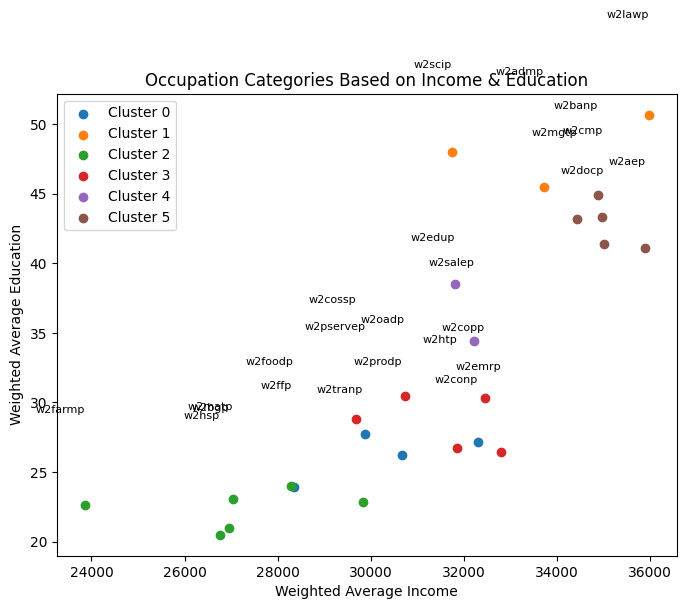

In [186]:
plt.figure(figsize=(8,6))
for cl in range(k):
    cluster_data = agg_df[agg_df['cluster'] == cl]
    plt.scatter(cluster_data['weighted_income'], cluster_data['weighted_white'], label=f'Cluster {cl}')
    for idx, row in cluster_data.iterrows():
        plt.text(row['weighted_income'], row['weighted_education'], row['occupation'],
                 fontsize=8, ha='right', va='bottom')
plt.xlabel('Weighted Average Income')
plt.ylabel('Weighted Average Education')
plt.title('Occupation Categories Based on Income & Education')
plt.legend()
plt.show()


In [176]:
agg_df['manual_cat'] = agg_df['occupation'].map(col_mapping)

In [179]:
# copy agg_df to clipboard
agg_df[['occupation','cluster','manual_cat']].to_clipboard()

The artist, designer, and journalist variable has high explanatory power in the 22nd. Going to re-run some of the models from chapter 2 to see if it makes a difference

In [25]:
dsa_cand = ['Tiffany Caban','Alexa Aviles','Michael Hollingsworth','Brandon West','Jaslin Kaur','Chi A. Osse']
cluster_four = ['Tiffany Caban','Alexa Aviles','Chi A. Osse','Jennifer Gutierrez','Pierina Ana Sanchez','Shahana K. Hanif','Lincoln Restler',
                'Amanda Farias','Sandy Nurse','Julie Won']
i_vars = ['log_mhhi21','nhw21p','cvap21bapp','w2admp','w2cmp']

In [30]:
full_results_dsa = full_results[full_results['candidate'].isin(dsa_cand)]

In [31]:
frd_oc = full_results_dsa.merge(occ_df, left_on='ed_name', right_on='ElectDist')

In [32]:
frd_oc['log_mhhi21'] = np.log(frd_oc['mhhi21'])

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [33]:
frd_oc.to_csv('../../chapter_two/data/dsa_with_occupation.csv', index=False)

In [26]:
frd_oc[['ed_name','candidate','vote_share']+i_vars].sample(5)

,ed_name,candidate,vote_share,log_mhhi21,nhw21p,cvap21bapp,w2admp,w2cmp
555,33075,Jaslin Kaur,31.428571,10.452331,22.666104,43.367118,1.683153,2.739630
34,36020,Tiffany Caban,48.717949,10.179008,51.076115,67.579653,9.331029,7.158726
513,26049,Jaslin Kaur,13.422819,10.155122,39.208247,51.701971,1.010695,3.388063
441,52098,Brandon West,28.611898,10.399690,73.319909,80.601680,13.649806,9.082635
98,43039,Michael Hollingsworth,32.326284,10.533050,50.688352,41.843628,6.860750,2.187803


In [40]:
frd_oc.isnull().sum()

Precinct               0
vote                   0
total_vote_precinct    0
vote_share             0
ed_name                0
                      ..
kdh24p                 0
djt24p                 0
wfp24p                 0
con24p                 0
log_mhhi21             0
Length: 282, dtype: int64

In [41]:
print(np.isinf(frd_oc[['vote_share','log_mhhi21','nhw21p','cvap21bapp','w2admp','w2cmp']]).sum())


vote_share    0
log_mhhi21    3
nhw21p        0
cvap21bapp    0
w2admp        0
w2cmp         0
dtype: int64


In [30]:
inf_mask = np.isinf(frd_oc['log_mhhi21'])
frd_oc_clean = frd_oc[~inf_mask].copy()
target = frd_oc_clean['vote_share']
X = sm.add_constant(frd_oc_clean[['log_mhhi21','nhw21p','cvap21bapp','w2admp','w2cmp']])
mod1 = sm.OLS(target, X).fit()
print(mod1.summary())

                            OLS Regression Results                            
Dep. Variable:             vote_share   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     11.10
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           3.37e-10
Time:                        17:00:33   Log-Likelihood:                -2256.1
No. Observations:                 554   AIC:                             4524.
Df Residuals:                     548   BIC:                             4550.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.1256      5.257      2.877      0.0

In [23]:
inf_mask = np.isinf(frd_oc['log_mhhi21'])
frd_oc_clean = frd_oc[~inf_mask].copy()

formula = "vote_share ~ " + " + ".join(i_vars)
model_all = smf.ols(formula=formula, data=frd_oc_clean).fit()

candidate_models = {}
for candidate in frd_oc_clean["candidate"].unique():
    df_candidate = frd_oc_clean[frd_oc_clean["candidate"] == candidate]
    candidate_models[candidate] = smf.ols(formula=formula, data=df_candidate).fit()

all_models = candidate_models.copy()
all_models["All"] = model_all

# Pass the list of model objects and provide model names
summary = summary_col(list(all_models.values()),
                      model_names=list(all_models.keys()),
                      stars=True,
                      float_format='%0.3f')
print(summary)


               Pierina Ana Sanchez Tiffany Caban Lincoln Restler Jennifer Gutierrez Chi A. Osse Alexa Aviles Shahana K. Hanif    All   
---------------------------------------------------------------------------------------------------------------------------------------
Intercept      43.029***           3.737         51.325***       80.084***          -3.539      22.132       51.958***        61.972***
               (14.583)            (16.173)      (5.678)         (12.395)           (15.535)    (22.032)     (6.204)          (4.881)  
log_mhhi21     -0.669              2.380         -1.022***       -2.659**           1.014       0.140        -0.459           -2.052***
               (1.553)             (1.575)       (0.364)         (1.333)            (1.650)     (2.212)      (0.562)          (0.514)  
nhw21p         -0.485              -0.160**      0.577***        -0.239**           0.119       0.003        -0.443***        0.272*** 
               (0.405)             (0.076)     

In [34]:
with open("regression_summary.html", "w") as f:
    f.write(summary.as_html())

Let's take a look at the clustering from chapter 1 with new info 

In [13]:
fp = pd.read_csv('../../shiny_meta_council_clustering/faction_predictions.csv')
mc = pd.read_csv('../../shiny_meta_council_clustering/meta_clusters_with_formatted_name.csv')
wfp = pd.read_csv('../data/wfp_end.csv')

In [14]:
losers = ['John Choe','Tahirah Moore','Shirley Paul','Mino Lora','Harold C. Miller Jr.','Johanna Garcia','Aleda Gagarin','Moumita Ahmed','Adolfo Abreu','Amit Bagga','Jaslin Kaur','Amoy Barnes',
          'Alicka Ampry-Samuel','Felicia Singh','Austin I. Shafran','Juan D. Ardila','Jesse Laymon']

In [15]:
wfp_council = wfp[wfp['Race'].str.contains('Council')]
wfp_council['district_number'] = wfp_council['Race'].str.extract(r'(\d+)').astype(int)
wfp_council = wfp_council[~wfp_council['Candidate'].isin(losers)]

C:\Users\samtg\AppData\Local\Temp\ipykernel_16228\1337817001.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wfp_council['district_number'] = wfp_council['Race'].str.extract(r'(\d+)').astype(int)


In [16]:
mc = mc.merge(wfp_council[['district_number','Candidate']], left_on='district', right_on='district_number',how='left')

In [17]:
mc['wfp'] = mc['district_number'].notnull().astype(int)
mc.drop(columns=['district_number','member','Candidate'], inplace=True)

In [20]:
mc.to_csv('../data/meta_clusters_with_wfp.csv',index=False)

In [34]:
mc = pd.read_csv('../data/clusters_pc_lange_wfp.csv')

In [23]:
mc.rename(columns={'Unnamed: 2':'lange'}, inplace=True)

In [35]:
cluster_cols = ['k_spon','vote_cluster','finance_cluster','pc','wfp','lange']

In [36]:
df_cluster = mc[cluster_cols]

In [37]:
# elbow method to determine number of clusters
ks = range(1, 10)
costs = []
for k in ks:
    km = KModes(n_clusters=k, init='Huang', n_init=5, random_state=42)
    km.fit(df_cluster)
    costs.append(km.cost_)

Text(0.5, 1.0, 'Elbow Method for Optimal k')

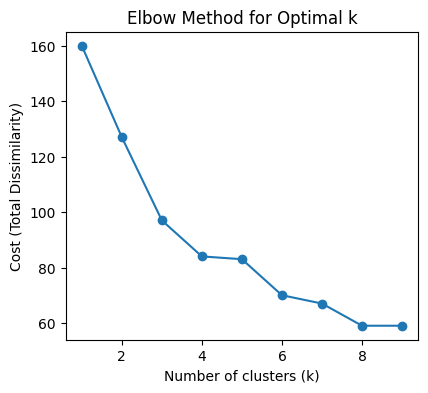

In [38]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(ks, costs, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Cost (Total Dissimilarity)')
plt.title('Elbow Method for Optimal k')

In [48]:
kmode = KModes(n_clusters=6, init='Cao', n_init=10, verbose=1,random_state=42)
kmode.fit(df_cluster)
mc['new_cluster'] = kmode.labels_

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 3, cost: 73.0
Run 1, iteration: 2/100, moves: 1, cost: 73.0


In [29]:
prog_clust = mc[mc['new_cluster'] == 3]['normalized_name'].tolist()

In [50]:
mc[['proper_name','new_cluster'] + cluster_cols].sort_values(by='new_cluster').to_csv('../data/meta_cluster_March17.csv',index=False)

In [ ]:
for col in demographic_cols:
    ag[col + '_quintile'] = pd.qcut(ag[col], 5, labels=False) + 1

In [ ]:
df_melted = full_results_winner.melt(
    id_vars=["ElectDist", "cvap21bapp", "mhhi21", 'nhw21p','nha21p','nhb21p','h21p','white_transplant_ratio'],
    value_vars=wp_cols,                            
    var_name="occupation",                          
    value_name="percentage"                         
)
df_filtered = df_melted[df_melted["percentage"] > 0]
df_filtered.groupby("occupation").agg({
    "mhhi21": "mean",
    "cvap21bapp": "mean"
}).round(2).reset_index()

In [57]:
df_melted = full_results_winner.melt(
    id_vars=["ElectDist", "cvap21bapp", "mhhi21", 'nhw21p','nha21p','nhb21p','h21p','white_transplant_ratio'],
    value_vars=wp_cols,                            
    var_name="occupation",                          
    value_name="percentage"                         
)
df_filtered = df_melted[df_melted["percentage"] > 0]
def weighted_avg(group, value_col, weight_col):
    return np.average(group[value_col], weights=group[weight_col])
occ_ag = df_filtered.groupby("occupation").apply(
    lambda x: pd.Series({
        "mhhi21_weighted": weighted_avg(x, "mhhi21", "percentage"),
        "cvap21bapp_weighted": weighted_avg(x, "cvap21bapp", "percentage")
    })
).round(2).reset_index()

In [58]:
for col in ['mhhi21_weighted', 'cvap21bapp_weighted']:
    occ_ag[col + '_quintile'] = pd.qcut(occ_ag[col], 4, labels=False) + 1

In [65]:
occ_ag[occ_ag['occupation'] == 'w2admp'][['occupation','mhhi21_weighted_quintile','cvap21bapp_weighted_quintile']]

,occupation,mhhi21_weighted_quintile,cvap21bapp_weighted_quintile
0,w2admp,3,4


John Survey Data

In [27]:
dsa_fav = pd.read_excel("../data/Goodson crosstabs.xlsx", 
                    sheet_name="dsa")  
aoc = pd.read_excel("../data/Goodson crosstabs.xlsx", 
                    sheet_name="aoc") 
l_nyc = pd.read_excel("../data/Goodson crosstabs.xlsx", 
                    sheet_name="leave_nyc") 
challenge = pd.read_excel("../data/Goodson crosstabs.xlsx", 
                    sheet_name="challenge") 

In [28]:
dsa_fav['district_number'] = dsa_fav['district'].str.extract(r'(\d+)').astype(int)
aoc['district_number'] = aoc['district'].str.extract(r'(\d+)').astype(int)
l_nyc['district_number'] = l_nyc['district'].str.extract(r'(\d+)').astype(int)
challenge['district_number'] = challenge['district'].str.extract(r'(\d+)').astype(int)

In [29]:
dsa_fav['dsa_favorable'] = dsa_fav['somewhat_favorable'] + dsa_fav['very_favorable']
dsa_fav['dsa_unfavorable'] = dsa_fav['somewhat_unfavorable'] + dsa_fav['very_unfavorable']
dsa_fav = dsa_fav[['district_number','dsa_favorable','dsa_unfavorable']]
aoc['aoc_favorable'] = aoc['somewhat_favorable'] + aoc['very_favorable']
aoc['aoc_unfavorable'] = aoc['somewhat_unfavorable'] + aoc['very_unfavorable']
aoc = aoc[['district_number','aoc_favorable','aoc_unfavorable']]

In [30]:
aoc_dsa = pd.merge(aoc, dsa_fav, on='district_number', how='left')

In [31]:
aoc_dsa = aoc_dsa.merge(challenge,on='district_number', how='left')
aoc_dsa = aoc_dsa.merge(l_nyc, on='district_number', how='left')

In [32]:
aoc_dsa['diff'] = aoc_dsa['aoc_favorable'] - aoc_dsa['dsa_favorable']

In [34]:
aoc_dsa[aoc_dsa['district_number'] == 36]

,district_number,aoc_favorable,aoc_unfavorable,dsa_favorable,dsa_unfavorable,district_x,1 Housing cost,2 Poor public spaces,3 High taxes,4 COVID infection,5 Public transit,6 Lack of employment,7 High cost of living,8 Crime and public safety,9 Quality of public education,10 Shelters neaarby,11 Traffic and congestion,district_y,no,yes,diff
35,36,0.773663,0.098765,0.495763,0.114407,36 BK36 Bedford Stuyvesant,0.556452,0.044355,0.03629,0.020161,0.048387,0.048387,0.137097,0.056452,0.020161,0.004032,0.028226,36 BK36 Bedford Stuyvesant,0.35743,0.64257,0.2779


In [22]:
cc_gpd = gpd.read_file('../../neighborhoods_ccdistricts/data/shapefiles/city_council/nycc.shp')

In [23]:
cc_gpd = cc_gpd.merge(dsa_fav, left_on='CounDist', right_on='district_number', how='left')

In [24]:
aoc_gpd = cc_gpd.merge(aoc, left_on='CounDist', right_on='district_number', how='left')

In [25]:
aoc_dsa_gpd = cc_gpd.merge(aoc_dsa, left_on='CounDist', right_on='district_number', how='left')

In [ ]:
cc_gpd['largest_cat'] = cc_gpd['largest_cat'].astype('category')
aoc_gpd['largest_cat'] = aoc_gpd['largest_cat'].astype('category')

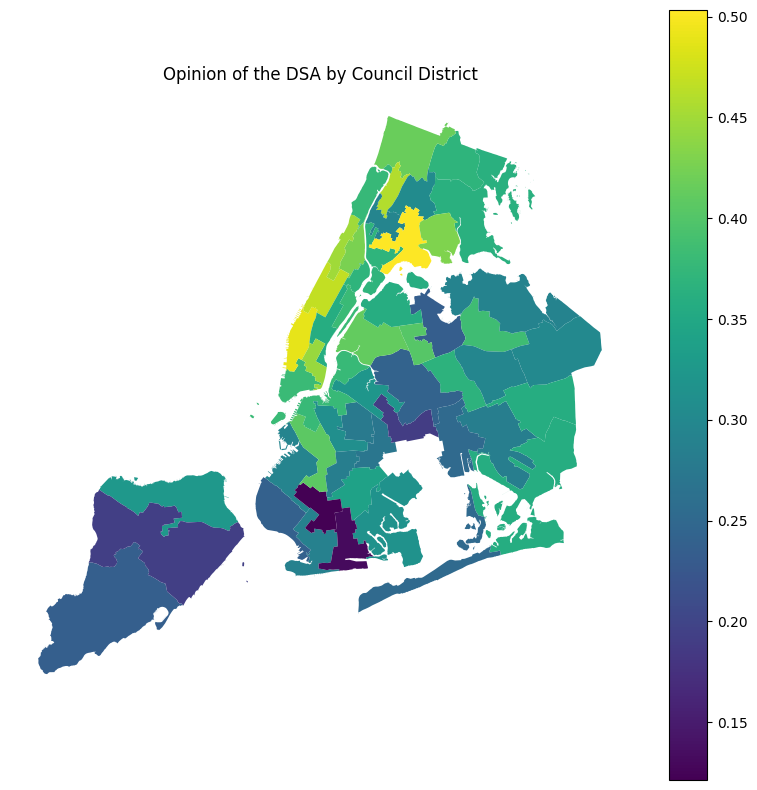

In [77]:
aoc_dsa_gpd.plot(column='diff',legend=True, figsize=(10, 10))
plt.title("Opinion of the DSA by Council District")
plt.axis('off')
plt.show()

In [90]:
aoc_dsa.columns

Index(['district_number', 'aoc_favorable', 'aoc_unfavorable', 'dsa_favorable',
       'dsa_unfavorable', 'district_x', '1 Housing cost',
       '2 Poor public spaces', '3 High taxes', '4 COVID infection',
       '5 Public transit', '6 Lack of employment', '7 High cost of living',
       '8 Crime and public safety', '9 Quality of public education',
       '10 Shelters neaarby', '11 Traffic and congestion', 'district_y', 'no',
       'yes'],
      dtype='object')

In [91]:
cor_cols = ['aoc_favorable', 'aoc_unfavorable', 'dsa_favorable',
       'dsa_unfavorable',  '1 Housing cost',
       '2 Poor public spaces', '3 High taxes', '4 COVID infection',
       '5 Public transit', '6 Lack of employment', '7 High cost of living',
       '8 Crime and public safety', '9 Quality of public education',
       '10 Shelters neaarby', '11 Traffic and congestion','no', 'yes']
cor_matrix = aoc_dsa[cor_cols].corr()

In [95]:
cor_matrix.sort_values(by='1 Housing cost', ascending=False)

,aoc_favorable,aoc_unfavorable,dsa_favorable,dsa_unfavorable,1 Housing cost,2 Poor public spaces,3 High taxes,4 COVID infection,5 Public transit,6 Lack of employment,7 High cost of living,8 Crime and public safety,9 Quality of public education,10 Shelters neaarby,11 Traffic and congestion,no,yes
1 Housing cost,0.629698,-0.719848,0.777456,-0.796418,1.000000,0.100166,-0.673453,0.194189,0.154581,0.125402,-0.240382,-0.743294,0.048397,-0.496358,-0.722118,-0.163430,0.163430
dsa_favorable,0.802253,-0.777936,1.000000,-0.745327,0.777456,0.136398,-0.602761,0.145939,0.274891,0.147353,-0.207201,-0.800545,-0.095900,-0.519835,-0.493028,0.171322,-0.171322
aoc_favorable,1.000000,-0.939373,0.802253,-0.833908,0.629698,0.237847,-0.546056,-0.039109,0.442998,0.058640,-0.196064,-0.781662,0.148277,-0.553171,-0.442183,0.312338,-0.312338
4 COVID infection,-0.039109,-0.066754,0.145939,-0.258357,0.194189,0.066828,-0.265660,1.000000,-0.044114,0.443826,-0.140997,-0.080961,-0.058591,-0.014883,-0.385601,-0.507162,0.507162
yes,-0.312338,0.141195,-0.171322,-0.014443,0.163430,-0.088051,-0.074853,0.507162,-0.273365,0.363264,-0.012335,0.182586,-0.056547,0.045850,-0.255751,-1.000000,1.000000
5 Public transit,0.442998,-0.396235,0.274891,-0.295775,0.154581,-0.106278,-0.165213,-0.044114,1.000000,-0.131119,0.011588,-0.309529,0.261097,-0.400849,-0.326812,0.273365,-0.273365
6 Lack of employment,0.058640,-0.225655,0.147353,-0.298041,0.125402,0.144890,-0.345808,0.443826,-0.131119,1.000000,-0.135514,-0.027243,0.097590,-0.130945,-0.306400,-0.363264,0.363264
2 Poor public spaces,0.237847,-0.287260,0.136398,-0.297200,0.100166,1.000000,-0.358442,0.066828,-0.106278,0.144890,-0.166786,0.008327,0.033999,-0.078425,-0.297972,0.088051,-0.088051
9 Quality of public education,0.148277,-0.211915,-0.095900,-0.235816,0.048397,0.033999,-0.248791,-0.058591,0.261097,0.097590,0.077628,-0.146865,1.000000,0.191570,-0.175827,0.056547,-0.056547
no,0.312338,-0.141195,0.171322,0.014443,-0.163430,0.088051,0.074853,-0.507162,0.273365,-0.363264,0.012335,-0.182586,0.056547,-0.045850,0.255751,1.000000,-1.000000


In [37]:
fwe['matched_name'].unique()

array(['Michael D Hollingsworth', 'Robert Waterman', 'Rodrigo Camarena',
       'Tahirah A Moore', 'Alexa Aviles', 'Chi Osse', 'Crystal Hudson',
       'Henry L Butler', 'Jacqueline Painter', 'Reginald Swiney',
       'Yu Lin'], dtype=object)

In [ ]:
thirty_five = ['Michael D Hollingsworth', 'Crystal Hudson']
thirty_six = ['Chi Osse','Henry L Butler','Tahirah A Moore']